# PACE OOD PCA

In [62]:
# imports
from importlib import reload
import numpy as np
import os

import h5py
import xarray

from scipy.spatial import Delaunay
from sklearn import decomposition

from matplotlib import pyplot as plt

from oceancolor.pace import io as pace_io
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import pca

In [127]:
def plot_pace(pace_wave, pace_Rrs, pace_recon, l23_fit, idx):
    fig = plt.figure(figsize=(6,6))
    plt.clf()
    ax = plt.gca()
    #
    ax.plot(pace_wave, pace_Rrs[idx], label='PACE orig')
    ax.plot(pace_wave, pace_recon[idx], label='PCA')
    #
    ax.plot(pace_wave, l23_fit.mean_, label='PCA mean')
    #
    ax.axhline(0., color='k', ls=':')
    #
    ax.legend()
    plt.show()

# Load

## PACE

In [3]:
ex_pace_file = os.path.join(os.getenv('OS_COLOR'),
                       'data', 'PACE', 'early',
                       'PACE_OCI.20240416T093158.L2.OC_AOP.V1_0_0.NRT.nc')

In [138]:
pace_xds, flags = pace_io.load_oci_l2(ex_pace_file)

## Loisel+2023

In [6]:
X, Y = 4, 0
l23_ds = loisel23.load_ds(X, Y)

In [11]:
l23_ds.Lambda.data

array([350., 355., 360., 365., 370., 375., 380., 385., 390., 395., 400.,
       405., 410., 415., 420., 425., 430., 435., 440., 445., 450., 455.,
       460., 465., 470., 475., 480., 485., 490., 495., 500., 505., 510.,
       515., 520., 525., 530., 535., 540., 545., 550., 555., 560., 565.,
       570., 575., 580., 585., 590., 595., 600., 605., 610., 615., 620.,
       625., 630., 635., 640., 645., 650., 655., 660., 665., 670., 675.,
       680., 685., 690., 695., 700., 705., 710., 715., 720., 725., 730.,
       735., 740., 745., 750.], dtype=float32)

In [27]:
l23_Rrs = l23_ds.Rrs.data
l23_Rrs.shape

(3320, 81)

# Pre-Process

## PACE

### Grab the ok set

In [7]:
pace_keep = flags == 0

In [35]:
pace_Rrs = pace_xds.Rrs.data[pace_keep]

In [36]:
pace_Rrs.shape

(506051, 184)

## Cut down wavelengths

In [37]:
min_wv = 400.
gd_wave = (pace_xds.wavelength >= min_wv)
pace_wave = pace_xds.wavelength[gd_wave]

In [38]:
pace_Rrs = pace_Rrs[:, gd_wave]

In [39]:
pace_Rrs.shape

(506051, 159)

## L23

## Rebin to PACE wavelengths

In [40]:
#wave_bins = (np.roll(pace_wave,-1) + pace_wave)/2.
## Edge
#wave_bins[-1] = pace_wave[-1] + (pace_wave[-1]-pace_wave[-2])/2.
#wave0 = pace_wave[0] - (pace_wave[1]-pace_wave[0])/2.
## Add the first
#wave_bins = np.append([wave0], wave_bins)
#wave_bins

In [76]:
l23_Rrs.shape

(3320, 81)

In [77]:
rebin_l23 = np.zeros((l23_Rrs.shape[0], pace_wave.size))

In [78]:
reload(spectra)
#
for kk in range(rebin_l23.shape[0]):
    rebin_l23[kk,:], _ = spectra.rebin(l23_ds.Lambda.data, l23_Rrs[kk], pace_wave)

### Check

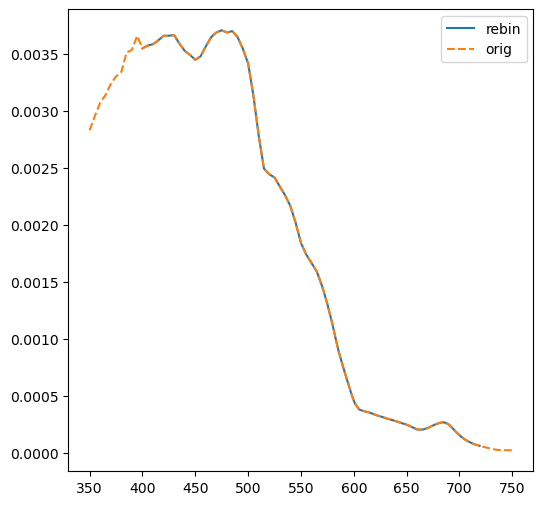

In [79]:
idx = 1000

fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()
#
ax.plot(pace_wave, rebin_l23[idx], label='rebin')
ax.plot(l23_ds.Lambda.data, l23_Rrs[idx], '--', label='orig')
#
ax.legend()
plt.show()

# PCA

## Fit L23

In [80]:
l23_fit = pca.fit_normal(rebin_l23, 5)

In [81]:
np.cumsum(l23_fit.explained_variance_ratio_)

array([0.96157456, 0.98573602, 0.99787102, 0.99940198, 0.99976122])

### Plot

In [101]:
l23_fit.components_.shape

(5, 159)

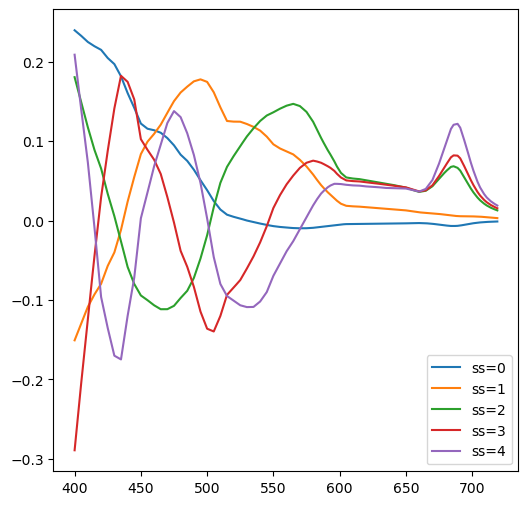

In [102]:
fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()
#
for ss in range(l23_fit.components_.shape[0]):
    ax.plot(pace_wave, l23_fit.components_[ss], label=f'ss={ss}')
#
ax.legend()
plt.show()

## Decompose L23

In [82]:
l23_coeff = l23_fit.transform(rebin_l23)

## Apply to PACE

In [83]:
pace_coeff = l23_fit.transform(pace_Rrs)

In [84]:
# Reconstruct
pace_recon = np.dot(pace_coeff, l23_fit.components_) + l23_fit.mean_

## Check a few

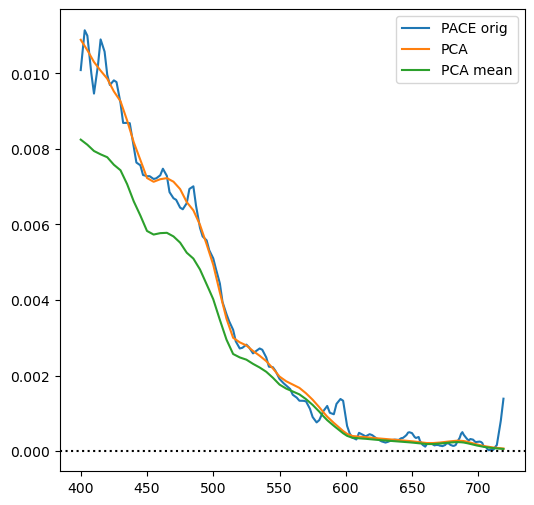

In [128]:
idx = 500303

plot_pace(pace_wave, pace_Rrs, pace_recon, l23_fit, idx)

# Hull me

## Build

In [86]:
hull = Delaunay(l23_coeff)

## Query

In [87]:
pace_hull = hull.find_simplex(pace_coeff)
in_hull = pace_hull >= 0

In [88]:
np.sum(in_hull)

866

In [90]:
np.where(in_hull)[0][:10]

array([ 6952,  7409,  7624,  8136, 16905, 19360, 28103, 30150, 39163,
       40611])

## Out

In [91]:
idx_out = np.where(~in_hull)[0]
idx_out

array([     0,      1,      2, ..., 506048, 506049, 506050])

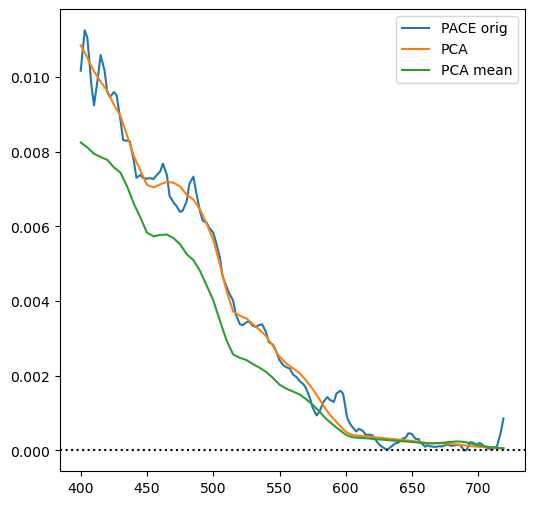

In [129]:
idx = idx_out[70000]

plot_pace(pace_wave, pace_Rrs, pace_recon, l23_fit, idx)

## Too bright?

In [94]:
np.max(rebin_l23)

0.02621000085491687

In [111]:
np.max(pace_Rrs)

0.054008

# Examine the coefficients

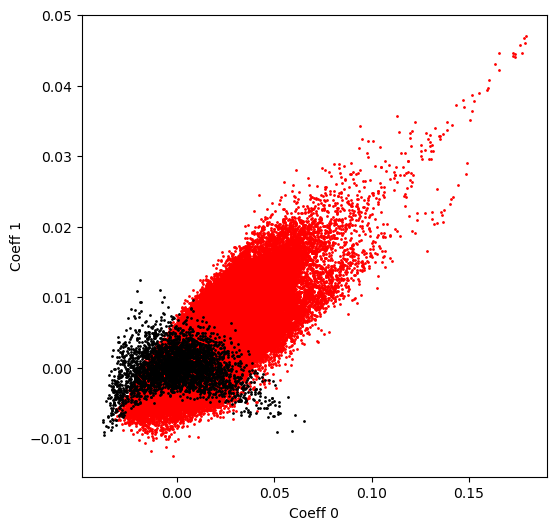

In [137]:
c0, c1 = 0, 1
fig = plt.figure(figsize=(6,6))
plt.clf()
ax = plt.gca()

ax.scatter(pace_coeff[:,c0], pace_coeff[:,c1], color='r', s=1)
ax.scatter(l23_coeff[:,c0], l23_coeff[:,c1], color='k',s=1)
#
ax.set_xlabel(f'Coeff {c0}')
ax.set_ylabel(f'Coeff {c1}')
#
plt.show()

## High one

In [112]:
high = (pace_coeff[:,0] > 0.07) & (pace_coeff[:,1] > 0.01)
np.sum(high)

1019

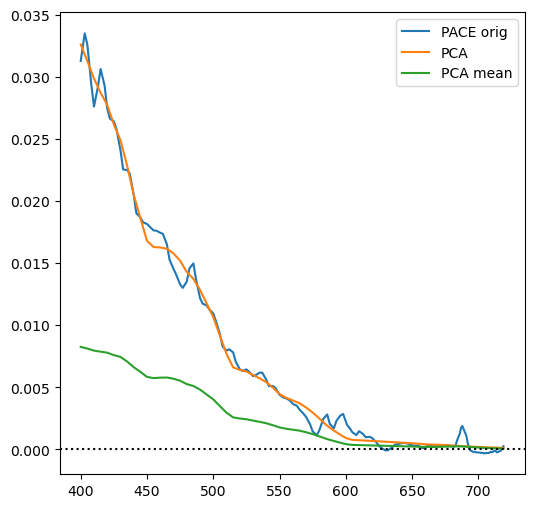

In [130]:
idx = np.where(high)[0][100]

plot_pace(pace_wave, pace_Rrs, pace_recon, l23_fit, idx)

## Low one

In [121]:
low = (np.abs(pace_coeff[:,0])<0.007) & (pace_coeff[:,1] < -0.005)
np.sum(low)

1054

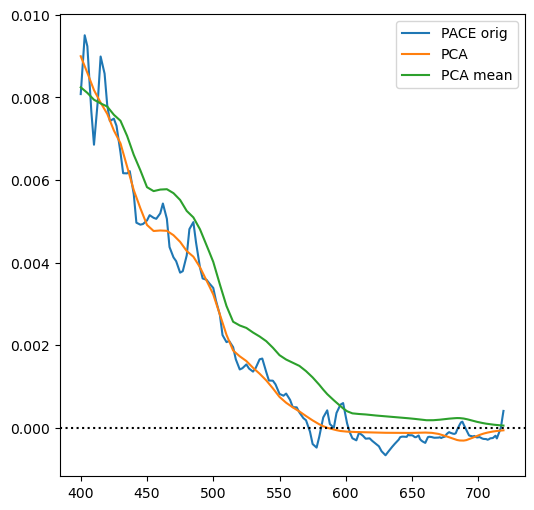

In [131]:
idx = np.where(low)[0][100]

plot_pace(pace_wave, pace_Rrs, pace_recon, l23_fit, idx)